In [173]:
import jax
from jax import numpy as jp
import matplotlib.pyplot as plt
from IPython.display import HTML
from brax.io import model, html
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from crl_new import networks
from utils import get_env_config, create_env
import pickle
import numpy as np

In [174]:
RUN_FOLDER_PATH = './runs/run_ant_checkpointing_s_1'

In [175]:
params = model.load_params(RUN_FOLDER_PATH + '/ckpt/final')
processor_params, policy_params, encoders_params = params
sa_encoder_params, g_encoder_params = encoders_params['sa_encoder'], encoders_params['g_encoder']

In [176]:
args_path = RUN_FOLDER_PATH + '/args.pkl'

with open(args_path, "rb") as f:
    args = pickle.load(f)

config = get_env_config(args)

In [177]:
env = create_env(args)
obs_size = env.observation_size
action_size = env.action_size

In [178]:
crl_networks = networks.make_crl_networks(config, obs_size, action_size)

inference_fn = networks.make_inference_fn(crl_networks)
inference_fn = inference_fn(params[:2])

sa_encoder = lambda obs: crl_networks.sa_encoder.apply(processor_params, sa_encoder_params, obs)
g_encoder = lambda obs: crl_networks.g_encoder.apply(processor_params, g_encoder_params, obs)

In [179]:
NUM_EPISODES = 5

jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)


trajectories = []
rollouts = []

for episode in range(NUM_EPISODES):
    trajectory = []
    rng = jax.random.PRNGKey(seed=episode)
    state = jit_env_reset(rng=rng)
    for _ in range(1000):
        rollouts.append(state.pipeline_state)
        act_rng, rng = jax.random.split(rng)
        act, _ = jit_inference_fn(state.obs, act_rng)
        trajectory.append((state,act))
        state = jit_env_step(state, act)
    trajectories.append(trajectory)

In [180]:
HTML(html.render(env.sys.tree_replace({'opt.timestep': env.dt}), rollouts))

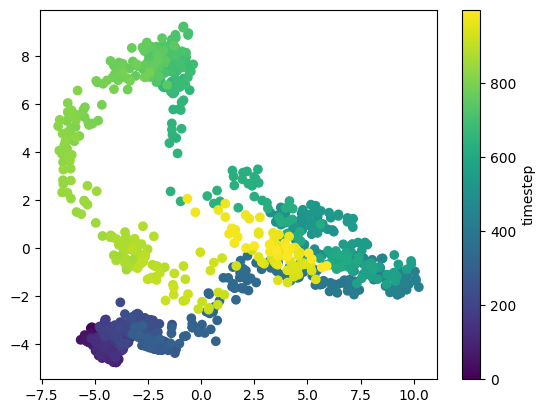

In [193]:
TRAJECTORY_TO_DRAW = 0

raw_observations = np.array([state.obs for (state, _) in trajectories[TRAJECTORY_TO_DRAW]])
actions = np.array([act for (_, act) in trajectories[TRAJECTORY_TO_DRAW]])

observations = raw_observations[:, :config.obs_dim]

encoded_sa = sa_encoder(jp.concatenate((observations, actions), axis = 1))

scaled_encodings = StandardScaler().fit_transform(encoded_sa)
features = PCA(n_components=2).fit_transform(scaled_encodings)

plt.scatter(features[:,0], features[:,1], c=np.arange(0, 1000))
plt.colorbar(label="timestep")